In [1]:
!pip install "qiskit==1.4.2" "qiskit-machine-learning>=0.8.2"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.7 MB/s eta 0:00:00


In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
estimator = Estimator()

In [4]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=eb3df7868b3566a0f4eee832251de9533ce71091ccad4490fe4bdebe8adee570
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [7]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

In [9]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

In [10]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


In [11]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

## Test on IBM Dataset

In [12]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [13]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

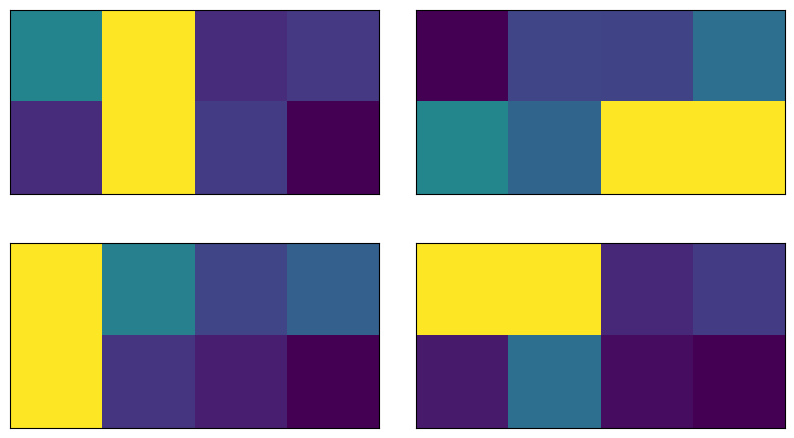

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

In [16]:
feature_map = ZFeatureMap(8)

In [17]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

In [20]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [21]:

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

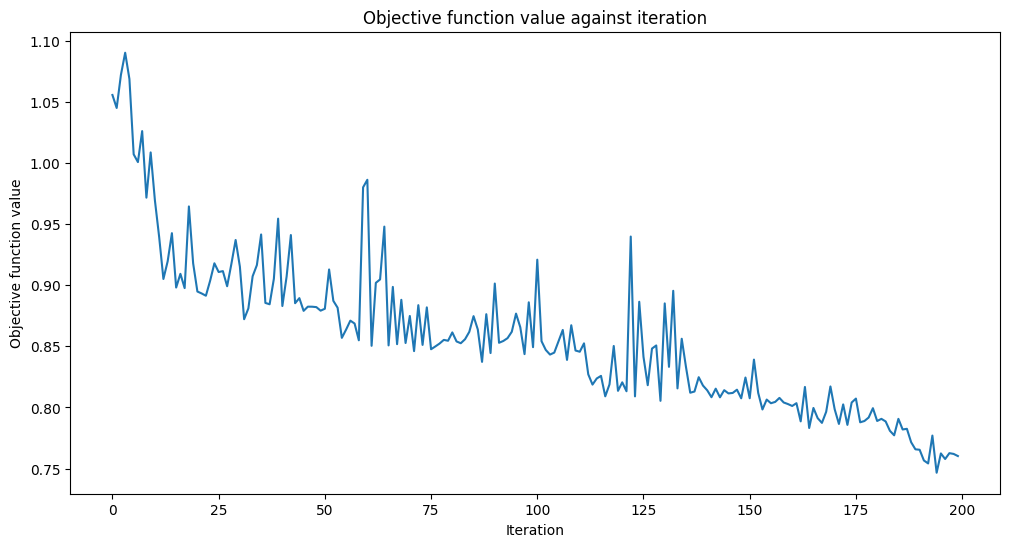

Accuracy from the train data : 68.57%


In [22]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [23]:
!pip install qiskit-aer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.1 MB/s eta 0:00:00


In [24]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

## Test on CIFAR-10 dataset

In [26]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

resize_to = 2  # you can change this value to make the image smaller or larger
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # convert to grayscale
    transforms.Resize((resize_to, resize_to)),    # resize the image
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# labels of bird and dog are 2 and 5
tr_cd_idx = [i for i, (_, label) in enumerate(trainset) if label in (2, 5)]
tr_cd_dataset = Subset(trainset, tr_cd_idx)
ts_cd_idx = [i for i, (_, label) in enumerate(testset) if label in (2, 5)]
ts_cd_dataset = Subset(testset, ts_cd_idx)

trainloader = DataLoader(tr_cd_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(ts_cd_dataset, batch_size=64, shuffle=False)


In [27]:
# Extract images and labels from Subset
train_images = []
train_labels = []

for img, label in tr_cd_dataset:
    train_images.append(img.numpy().flatten())  # flatten 1x8x8 to 64D vector
    train_labels.append(0 if label == 2 else 1)  # Map bird(2)->0, dog(5)->1

# Convert to NumPy arrays
x = np.asarray(train_images)
y = np.asarray(train_labels)
x.shape

(10000, 4)

In [28]:
feature_map = ZFeatureMap(4, reps=1)

ansatz = QuantumCircuit(4, name="Ansatz")
ansatz.compose(conv_layer(4,  "c1"),  range(4), inplace=True)
ansatz.compose(pool_layer([0,1], [2,3], "pl1"), range(4), inplace=True)

circuit = QuantumCircuit(4)
circuit.compose(feature_map, range(4), inplace=True)
circuit.compose(ansatz,      range(4), inplace=True)

observable = SparsePauliOp.from_list([("I"*3 + "Z", 1)])

In [29]:
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

In [30]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

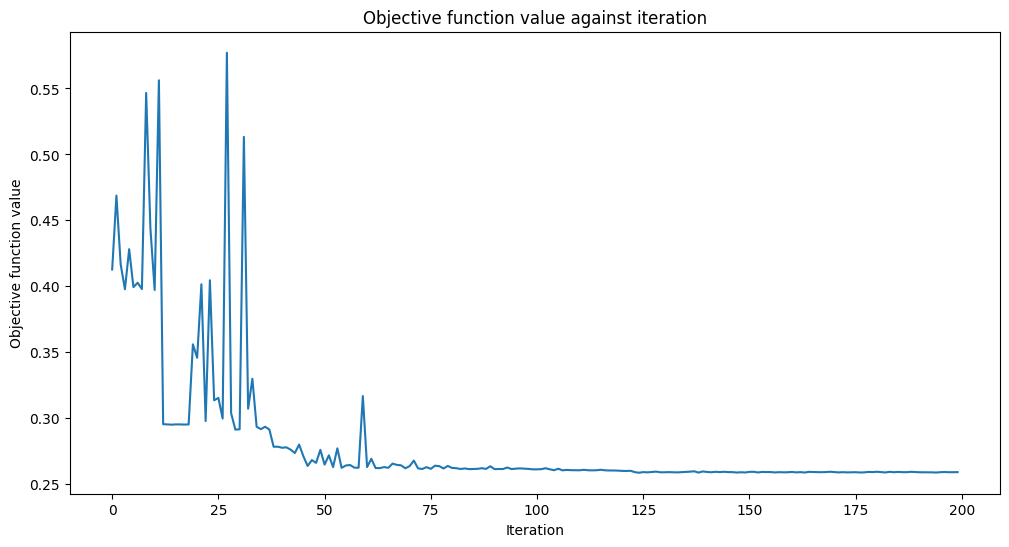

Accuracy from the train data : 50.0%


In [31]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

If we choose higher "resize_to", we will not get the result since it exceeds the runtime limit of Kaggle. Therefore, we compromise and choose "resize_to = 2". However, the result is not that well.